# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Log odds

When I was in grad school, I signed up for a class on Theory of Computation. 
On the first day of class, I was the first to arrive. A few minutes later, another student arrived. Because I was expecting most students in an advanced computer science class to be male, I was mildly surprised that the other student was female. 

Another female student arrived a few minutes later, which was sufficiently surprising that I started to think I was in the wrong room. When another female student arrived, I was confident I was in the wrong place, and it turned out I was.

As each student arrived, I used the observed data to update my belief that I was in the right place. We can use Bayes's Rule, which we saw in Chapter 5, to quantify the calculation I was doing intuitively.

I'll use $H$ to represent the hypothesis that I was in the right room, and $F$ to represent the observation that the first other student was female. Bayes's Rule gives us:

$O(H|F) = O(H) \frac{P(F|H)}{P(F|not H)}$

Before I saw the other students, I was confident I was in the right room, so I might assign prior odds of 10:1 in favor:

$O(H) = 10$

When I was in grad school, most advanced computer science classes were about 90% male, so if I was in the right room, the likelihood of the first female student was only 10%.

If we don’t assume I was in the right room, then the likelihood of the first female student was more like 50%, so the likelihood ratio is 1/5.

$O(H|F) = O(H) / 5 = 2$

After the first student, the posterior odds are 2:1 I was in the right room, or 66%.  After two students:

$O(H|FF) = O(H) / 25 = 2/5$

Which corresponds to probability 2/7.  And after three students:

$O(H|FFF) = 2/25$

At that point, I was right to believe I was in the wrong room.



Now let's see what those odds look like in terms of probability:

In [4]:
def prob(odds):
    return odds / (odds + 1)

In [5]:
index = ['prior', '1 student', '2 students', '3 students']

table = pd.DataFrame(index=index)
table['odds'] = [10, 2, 2/5, 2/25]
table['prob'] = prob(table['odds'])

table

,odds,prob
prior,10.00,0.909091
1 student,2.00,0.666667
2 students,0.40,0.285714
3 students,0.08,0.074074


Each update uses the same likelihood, but the changes in probability are not the same.  The first update decreases the probability by about 24 percentage points, the second by 38, and the third by 21.

That's normal for this kind of update, and in fact it's necessary; if the changes were the same size, we would quickly get negative probabilities.

In [6]:
table['prob'].diff()

prior              NaN
1 student    -0.242424
2 students   -0.380952
3 students   -0.211640
Name: prob, dtype: float64

The odds make a more obvious pattern.  Because each update multiplies the odds by the same likelihood ratio, the odds form a geometric sequence.

And that brings us to consider another way to represent uncertainty: **log odds**, which is the logarithm of odds, usually expressed using the natural log (base $e$).

Adding log odds to the table:

In [7]:
table['log odds'] = np.log(table['odds'])
table

,odds,prob,log odds
prior,10.00,0.909091,2.302585
1 student,2.00,0.666667,0.693147
2 students,0.40,0.285714,-0.916291
3 students,0.08,0.074074,-2.525729


You might notice:

* When probability is greater than 0.5, odds are greater than 1, and log odds are positive.

* When probability is less than 0.5, odds are less than 1, and log odds are negative.

And you might also notice that the log odds are equally spaced.

In [8]:
table['log odds'].diff()

prior              NaN
1 student    -1.609438
2 students   -1.609438
3 students   -1.609438
Name: log odds, dtype: float64

The change in log odds after each update is the logarithm of the likelihood ratio.

In [9]:
np.log(1/5)

-1.6094379124341003

That's true in this example, and we can show that it's true in general by taking the log of both sides of Bayes's Rule.

$ \log O(H|F) = \log O(H) + \log \frac{P(F|H)}{P(F|not H)}$

On a log odds scale, a Bayesian update is additive.  So if $F^x$ means that $x$ female students arrive while I am waiting, the posterior log odds that I am in the right room are:

$ \log O(H|F^x) = \log O(H) + x \log \frac{P(F|H)}{P(F|not H)}$

This equation represents a linear relationship between the evidence and the posterior log odds.  In this example it is literally true, but even when it's not, it is common to use a linear function to model the relationship between an explanatory variable, $x$, and a dependent variable expressed in log odds.

$ \log O(H | x) = \beta_0 + \beta_1 x$

where $\beta_0$ and $\beta_1$ are unknown parameters.  This equation is the basis of logistic regression.

## Logistic regression

[](https://en.wikipedia.org/wiki/Logistic_regression)

## The Space Shuttle problem

Here's an example from Cameron Davidon-Pilon's book, [Bayesian Methods for Hackers](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC2.ipynb)

> "On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend."

The dataset is originally from [this paper](https://amstat.tandfonline.com/doi/abs/10.1080/01621459.1989.10478858), but we can download it from Davidson-Pilon's site.

In [10]:
import os

if not os.path.exists('challenger_data.csv'):
    !wget https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv

In [11]:
data = pd.read_csv('challenger_data.csv', parse_dates=[0])

data.rename(columns={'Damage Incident': 'Damage'}, inplace=True)

# dropping row 3, in which Damage Incident is NaN,
# and row 24, which is the record for the Challenger
data.drop(labels=[3, 24], inplace=True)

data.sort_values(by='Temperature', inplace=True)

data

,Date,Temperature,Damage
14,1985-01-24,53,1
9,1984-02-03,57,1
23,1986-01-12,58,1
10,1984-04-06,63,1
0,1981-04-12,66,0
15,1985-04-12,67,0
13,1984-11-08,67,0
5,1983-04-04,67,0
4,1982-01-11,68,0
2,1982-03-22,69,0


In [12]:
data['y'] = (data['Damage'] == '1').astype(int)
data['y'].sum()

7

In [13]:
def plot_data(data):

    plt.plot(data['Temperature'], data['y'], 'o', 
             color="C1", alpha=0.5)

    decorate(yticks=[0, 1],
         ylabel="Damage Incident?",
         xlabel="Outside temperature (deg F)",
         title="Defects of the Space Shuttle O-Rings vs temperature")

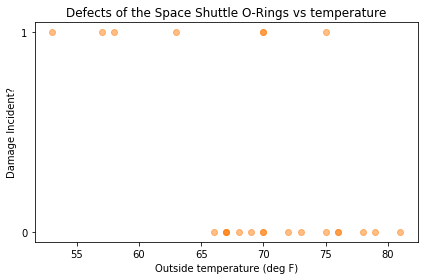

In [14]:
plot_data(data)

In [15]:
offset = data['Temperature'].mean()
data['x'] = data['Temperature'] - offset

In [16]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.logit(formula, data=data).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.441635
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Fri, 31 Jul 2020   Pseudo R-squ.:                  0.2813
Time:                        10:57:42   Log-Likelihood:                -10.158
converged:                       True   LL-Null:                       -14.134
Covariance Type:            nonrobust   LLR p-value:                  0.004804
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1076      0.580     -1.911      0.056      -2.244       0.028
x             -0.2322      0.108     -2.145      0.032      -0.444      -0.020
==============================================================================
"""

In [17]:
inter = -1.1
slope = -0.23

In [18]:
xs = np.arange(53, 83) - offset
log_odds = inter + slope * xs
odds = np.exp(log_odds)
ps = odds / (odds + 1)
ps.mean()

0.4153169290226892

In [19]:
from scipy.special import expit

ps = expit(inter + slope * xs)
ps.mean()

0.4153169290226892

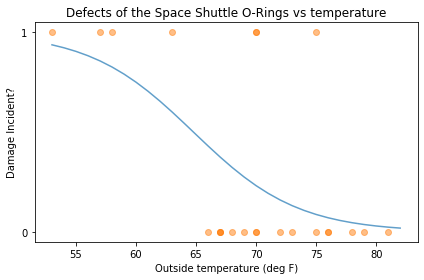

In [20]:
plt.plot(xs+offset, ps, color='C0', alpha=0.7)

plot_data(data)

In [21]:
ys = data['y']
xs = data['x']
ps = expit(inter + slope * xs)

likes = np.where(ys, ps, 1-ps)
likes

array([0.93761415, 0.85692728, 0.82635335, 0.60108788, 0.56954622,
       0.62480647, 0.62480647, 0.62480647, 0.67699586, 0.7251195 ,
       0.23147522, 0.76852478, 0.76852478, 0.23147522, 0.840238  ,
       0.86875553, 0.91293423, 0.08706577, 0.92956327, 0.92956327,
       0.95434883, 0.96338517, 0.97656933])

In [22]:
likes.prod()

3.877150978524181e-05

In [23]:
np.log(likes.prod())

-10.15782486493902

In [24]:
inters = np.linspace(-5, 1, 51)
prior_inter = Pmf(1.0, inters)
prior_inter.index.name = 'Intercept'

In [25]:
slopes = np.linspace(-0.8, 0.1, 51)
prior_slope = Pmf(1.0, slopes)
prior_slope.index.name = 'Slope'

In [26]:
def make_joint(s1, s2):
    """Compute the outer product of two Series.
    
    First Series across the columns;
    second goes goes down the rows.
    
    s1: Series
    s2: Series
    
    return: DataFrame
    """
    X, Y = np.meshgrid(s1, s2)
    return pd.DataFrame(X*Y, columns=s1.index, index=s2.index)

In [27]:
joint = make_joint(prior_inter, prior_slope)
joint.head()

Intercept,-5.00,-4.88,-4.76,-4.64,-4.52,-4.40,-4.28,-4.16,-4.04,-3.92,...,-0.08,0.04,0.16,0.28,0.40,0.52,0.64,0.76,0.88,1.00
Slope,,,,,,,,,,,,,,,,,,,,,
-0.800,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
-0.782,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
-0.764,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
-0.746,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
-0.728,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [28]:
joint_pmf = Pmf(joint.stack())
joint_pmf.head()

Slope  Intercept
-0.8   -5.00        1.0
       -4.88        1.0
       -4.76        1.0
       -4.64        1.0
       -4.52        1.0
dtype: float64

In [29]:
likelihood = joint_pmf.copy()

ys = data['y']
xs = data['x']

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = np.where(ys, ps, 1-ps)
    likelihood.loc[slope, inter] = likes.prod()

In [30]:
likelihood.sum()

0.007458138027414907

In [31]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

0.007458138027414907

In [32]:
posterior_pmf.max_prob()

(-0.242, -1.1600000000000001)

In [33]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

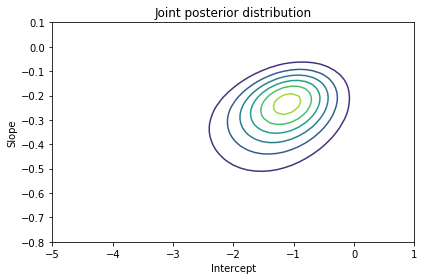

In [34]:
joint_posterior = posterior_pmf.unstack()
plot_contour(joint_posterior)
decorate(title='Joint posterior distribution')

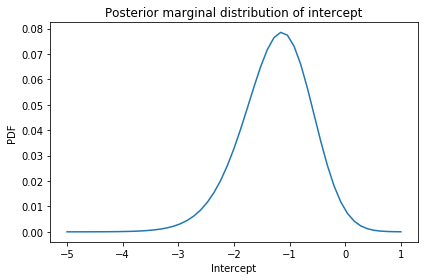

In [35]:
from utils import marginal

marginal_inter = marginal(joint_posterior, 0)
marginal_inter.plot()

decorate(xlabel='Intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

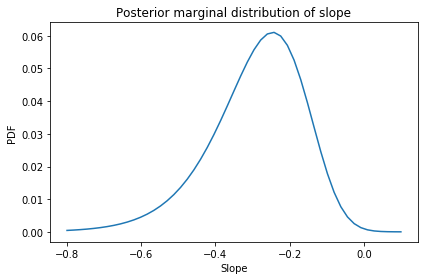

In [36]:
marginal_slope = marginal(joint_posterior, 1)
marginal_slope.plot()

decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [37]:
mean_slope = marginal_slope.mean()
mean_slope

-0.2898510066926141

In [38]:
np.exp(mean_slope)

0.7483750621480612

In [39]:
posterior_pmf.head()

Slope  Intercept
-0.8   -5.00        1.060829e-07
       -4.88        1.541822e-07
       -4.76        2.222242e-07
       -4.64        3.175042e-07
       -4.52        4.495006e-07
dtype: float64

In [40]:
sample = posterior_pmf.sample(101)
xs = np.arange(31, 83) - 70
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    pred[i] = expit(inter + slope * xs)
    
pred.shape

(101, 52)

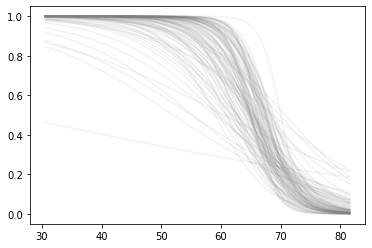

In [41]:
for ps in pred:
    plt.plot(xs+offset, ps, color='gray', alpha=0.1)

In [42]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
median.shape

(52,)

In [43]:
median

array([0.99993647, 0.99991459, 0.99988518, 0.99984563, 0.99979246,
       0.99972099, 0.99962492, 0.99949578, 0.99932221, 0.99908895,
       0.99881875, 0.99846854, 0.9980147 , 0.99733265, 0.99635229,
       0.99513107, 0.99369445, 0.99183743, 0.98943931, 0.98634634,
       0.981729  , 0.97558882, 0.96745358, 0.95771023, 0.9458333 ,
       0.93086158, 0.91356801, 0.89585552, 0.86483003, 0.82635335,
       0.79084063, 0.75250179, 0.69082947, 0.62433751, 0.549834  ,
       0.4880023 , 0.4192142 , 0.34796417, 0.29152273, 0.23866729,
       0.20718135, 0.16854141, 0.12830828, 0.09552212, 0.07043673,
       0.05520054, 0.04212806, 0.03279926, 0.02489204, 0.01798621,
       0.01297079, 0.0093406 ])

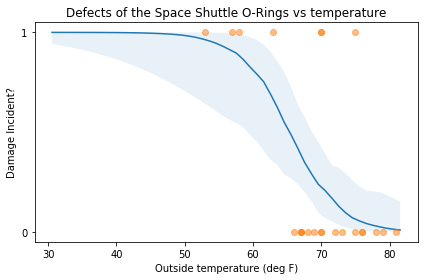

In [44]:
plt.fill_between(xs+offset, low, high, alpha=0.1)
plt.plot(xs+offset, median, color='C0')

plot_data(data)

## GSS data

In [45]:
# Load the data file

# TODO: Update this to point to the ThinkBayes2 repo

import os

datafile = 'gss_eda.hdf5'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_eda.hdf5

In [46]:
gss = pd.read_hdf(datafile, 'gss')
gss.shape

(64814, 166)

In [47]:
gss['grass'].value_counts(dropna=False)

NaN    27268
2.0    25662
1.0    11884
Name: grass, dtype: int64

In [48]:
gss['sex'].value_counts(dropna=False)

2    36200
1    28614
Name: sex, dtype: int64

In [49]:
gss['cohort'].describe()

count    64586.000000
mean      1948.846069
std         21.262659
min       1883.000000
25%       1934.000000
50%       1951.000000
75%       1964.000000
max       2000.000000
Name: cohort, dtype: float64

In [50]:
valid = gss.dropna(subset=['grass', 'sex', 'cohort']).copy()
valid.shape

(37427, 166)

In [51]:
valid['y'] = valid['grass'].replace(2, 0)
valid['y'].value_counts()

0.0    25572
1.0    11855
Name: y, dtype: int64

In [52]:
offset = valid['cohort'].mean()
valid['x'] = valid['cohort'] - offset

In [53]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.logit(formula, data=valid).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.582717
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                37427
Model:                          Logit   Df Residuals:                    37425
Method:                           MLE   Df Model:                            1
Date:                Fri, 31 Jul 2020   Pseudo R-squ.:                 0.06675
Time:                        10:57:47   Log-Likelihood:                -21809.
converged:                       True   LL-Null:                       -23369.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8491      0.012    -71.017      0.000      -0.873      -0.826
x              0.0317      0.001     52.197      0.000       0.031       0.033
==============================================================================
"""

In [54]:
data = valid.groupby('cohort')['y'].agg(['sum', 'count'])
data

,sum,count
cohort,,
1884.0,0.0,1
1886.0,0.0,3
1887.0,1.0,9
1888.0,0.0,3
1889.0,1.0,14
...,...,...
1996.0,40.0,47
1997.0,28.0,41
1998.0,11.0,17


In [55]:
data['x'] = data.index - offset
data.head()

,sum,count,x
cohort,,,
1884.0,0.0,1,-64.724243
1886.0,0.0,3,-62.724243
1887.0,1.0,9,-61.724243
1888.0,0.0,3,-60.724243
1889.0,1.0,14,-59.724243


In [56]:
def plot_data(data):
    fraction = data['sum'] / data['count']
    plt.plot(data.index, fraction, 'o', color='C1',
                  label='GSS data', alpha=0.3)
    
    decorate(xlabel='Year of birth',
             ylabel='Percent in favor',
             title='Support for legal marijuana vs cohort')

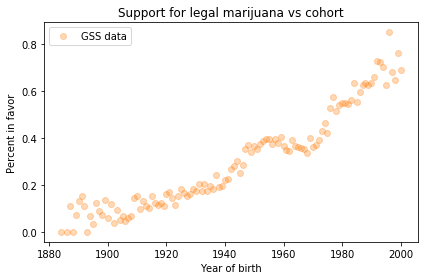

In [57]:
plot_data(data)

In [58]:
inter = -0.85
slope = 0.032

In [59]:
xs = data['x']

ps = expit(inter + slope * xs)
ps

cohort
1884.0    0.051117
1886.0    0.054312
1887.0    0.055979
1888.0    0.057694
1889.0    0.059459
            ...   
1996.0    0.659895
1997.0    0.667039
1998.0    0.674108
1999.0    0.681098
2000.0    0.688008
Name: x, Length: 116, dtype: float64

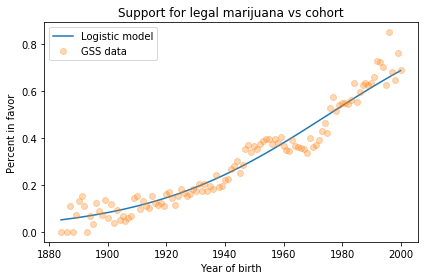

In [60]:
ps.plot(color='C0', label='Logistic model')

plot_data(data)

In [61]:
from scipy.stats import binom

ks = data['sum']
ns = data['count']
likes = binom.pmf(ks, ns, ps)

In [62]:
likes.prod()

1.374180525164937e-209

In [63]:
np.log(likes.prod())

-480.92242686400294

In [64]:
import sys
sys.float_info.min_exp

-1021

In [65]:
inters = np.linspace(-1.0, -0.6, 51)
prior_inter = Pmf(1.0, inters)
prior_inter.index.name = 'Intercept'

In [66]:
slopes = np.linspace(0.02, 0.04, 51)
prior_slope = Pmf(1.0, slopes)
prior_slope.index.name = 'Slope'

In [67]:
joint = make_joint(prior_inter, prior_slope)
joint.head()

Intercept,-1.000,-0.992,-0.984,-0.976,-0.968,-0.960,-0.952,-0.944,-0.936,-0.928,...,-0.672,-0.664,-0.656,-0.648,-0.640,-0.632,-0.624,-0.616,-0.608,-0.600
Slope,,,,,,,,,,,,,,,,,,,,,
0.0200,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0204,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0208,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0212,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0216,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [68]:
joint_pmf = Pmf(joint.stack())
joint_pmf.head()

Slope  Intercept
0.02   -1.000       1.0
       -0.992       1.0
       -0.984       1.0
       -0.976       1.0
       -0.968       1.0
dtype: float64

In [69]:
likelihood = joint_pmf.copy()

xs = data['x']
ks = data['sum']
ns = data['count']

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.pmf(ks, ns, ps)
    likelihood.loc[slope, inter] = likes.prod()

In [70]:
likelihood.sum()

2.1640938466678573e-208

In [71]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

2.1640938466678573e-208

In [72]:
posterior_pmf.max_prob()

(0.0316, -0.848)

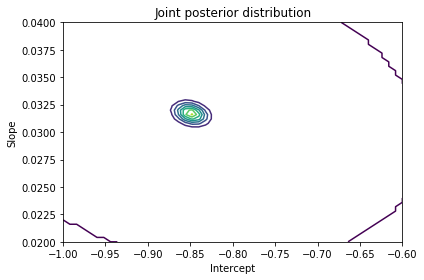

In [73]:
joint_posterior = posterior_pmf.unstack()

plot_contour(joint_posterior)
decorate(title='Joint posterior distribution')

In [74]:
marginal_inter = marginal(joint_posterior, 0)
marginal_slope = marginal(joint_posterior, 1)

marginal_inter.mean(), marginal_slope.mean()

(-0.8491556078449897, 0.03169425573731395)

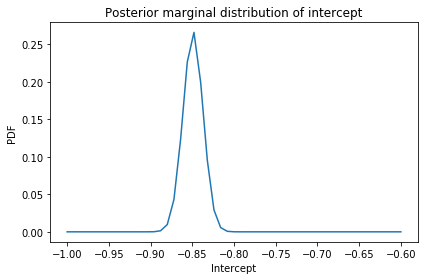

In [75]:
marginal_inter.plot()
decorate(xlabel='Intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

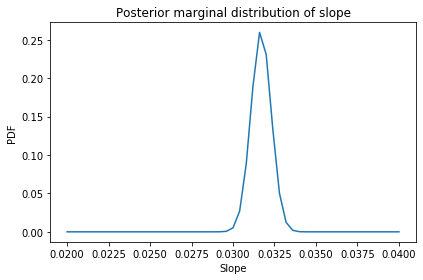

In [76]:
marginal_slope.plot()

decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [77]:
log_likelihood = joint_pmf.copy()

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    log_likes = binom.logpmf(ks, ns, ps)
    log_likelihood.loc[slope, inter] = log_likes.sum()

In [78]:
log_likelihood.max()

-480.8041799824062

In [79]:
likelihood2 = np.exp(log_likelihood - log_likelihood.max())

In [80]:
posterior2_pmf = joint_pmf * likelihood2
posterior2_pmf.normalize()

13.991952835762627

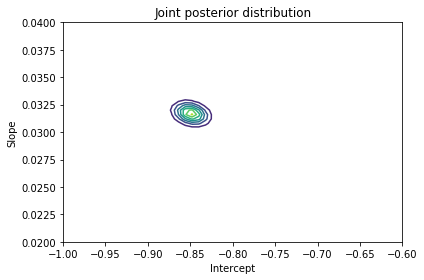

In [81]:
joint_posterior2 = posterior2_pmf.unstack()

plot_contour(joint_posterior2)
decorate(title='Joint posterior distribution')

In [82]:
marginal2_inter = marginal(joint_posterior2, 0)
marginal2_slope = marginal(joint_posterior2, 1)

marginal2_inter.mean(), marginal2_slope.mean()

(-0.8491556078449896, 0.03169425573731394)

In [83]:
marginal_inter.mean(), marginal_slope.mean()

(-0.8491556078449897, 0.03169425573731395)

In [84]:
sample = posterior_pmf.sample(101)
xs = data['x']
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    pred[i] = expit(inter + slope * xs)
    
pred.shape

(101, 116)

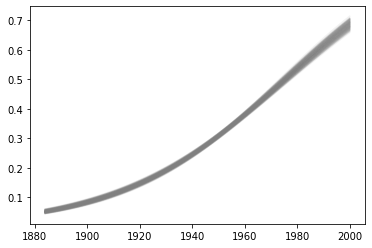

In [85]:
for ps in pred:
    plt.plot(xs+offset, ps, color='gray', alpha=0.1)

In [86]:
low, median, high = np.percentile(pred, [2.5, 50, 97.5], axis=0)
median.shape

(116,)

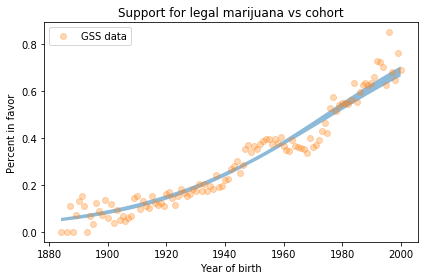

In [87]:
plt.fill_between(xs+offset, low, high, alpha=0.5)

plot_data(data)

## Bayesian regression

This notebook presents a simple example of Bayesian regression using sythetic data

### Data

Suppose there is a linear relationship between `x` and `y` with slope 2 and intercept 1, but the measurements of `y` are noisy; specifically, the noise is Gaussian with mean 0 and `sigma = 0.3`. 

In [88]:
slope = 2
inter = 1
sigma = 0.5

In [89]:
xs = np.linspace(0, 1, 12)

In [90]:
ys = inter + slope * xs + np.random.normal(0, sigma, len(xs))

In [91]:
slope, inter = 2, 1
resid = slope * xs + inter - ys
resid

array([ 0.3066181 ,  0.66158397, -0.0799532 , -0.0439027 ,  0.56108264,
        0.25382682,  0.20865216,  0.04732851, -0.2118511 , -0.19601266,
       -0.92963761,  0.67110299])

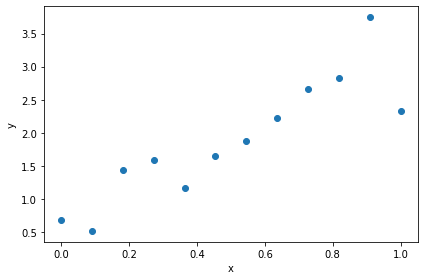

In [92]:
plt.plot(xs, ys, 'o')
decorate(xlabel='x', ylabel='y')

### Grid algorithm

We can solve the problem first using a grid algorithm, with uniform priors for slope, intercept, and sigma.

As an exercise, fill in this likelihood function, then test it using the code below.

Your results will depend on the random data you generated, but in general you should find that the posterior marginal distributions peak near the actual parameters.

In [93]:
slopes = np.linspace(0, 4, 51)
prior_slope = Pmf(1, slopes)
prior_slope.index.name = 'Slope'

In [94]:
inters = np.linspace(0, 3, 41)
prior_inter = Pmf(1, inters)
prior_inter.index.name = 'Intercept'

In [95]:
sigmas = np.linspace(0.01, 2.01, 31)
prior_sigma = Pmf(1, sigmas)
prior_sigma.index.name = 'Sigma'

In [96]:
def make_joint(s1, s2):
    """Compute the outer product of two Series.
    
    First Series across the columns;
    second goes goes down the rows.
    
    s1: Series
    s2: Series
    
    return: DataFrame
    """
    X, Y = np.meshgrid(s1, s2)
    return pd.DataFrame(X*Y, columns=s1.index, index=s2.index)

In [97]:
joint = make_joint(prior_slope, prior_inter)
joint.shape

(41, 51)

In [98]:
joint_pmf = Pmf(joint.transpose().stack())
joint_pmf.head()

Slope  Intercept
0.0    0.000        1
       0.075        1
       0.150        1
       0.225        1
       0.300        1
dtype: int64

In [99]:
prior3 = make_joint(prior_sigma, joint_pmf)
prior3.shape

(2091, 31)

In [100]:
slope, inter = 2, 1
resids = (slope * xs + inter) - ys
resids

array([ 0.3066181 ,  0.66158397, -0.0799532 , -0.0439027 ,  0.56108264,
        0.25382682,  0.20865216,  0.04732851, -0.2118511 , -0.19601266,
       -0.92963761,  0.67110299])

In [101]:
sigma_mesh, resid_mesh = np.meshgrid(prior_sigma.index, resids)
sigma_mesh.shape

(12, 31)

In [102]:
from scipy.stats import norm

densities = norm(0, sigma_mesh).pdf(resid_mesh)
densities.shape

(12, 31)

In [103]:
from scipy.stats import norm

densities = norm.pdf(resid_mesh, 0, sigma_mesh)
densities.shape

(12, 31)

In [104]:
like = densities.prod(axis=0)
like.shape
like

array([0.00000000e+00, 1.99193418e-79, 2.28671424e-20, 5.11885215e-09,
       1.59967106e-05, 2.68807983e-04, 6.38430005e-04, 6.51708089e-04,
       4.48763057e-04, 2.55863974e-04, 1.33597948e-04, 6.73114213e-05,
       3.36544089e-05, 1.69539128e-05, 8.67626620e-06, 4.52966336e-06,
       2.41718290e-06, 1.31924291e-06, 7.36268529e-07, 4.19929489e-07,
       2.44552897e-07, 1.45278545e-07, 8.79465813e-08, 5.41978490e-08,
       3.39671675e-08, 2.16290653e-08, 1.39806071e-08, 9.16549873e-09,
       6.08952373e-09, 4.09718860e-09, 2.78974273e-09])

In [105]:
posterior_sigma = prior_sigma * like
posterior_sigma.normalize()

0.0025498148765073178

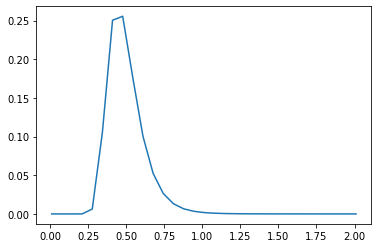

In [106]:
posterior_sigma.plot()

In [107]:
likelihood = prior3.copy()

for (slope, inter), sigmas in prior3.iterrows():
    resid = slope * xs + inter - ys
    sigma_mesh, resid_mesh = np.meshgrid(prior_sigma.index, resid)
    densities = norm.pdf(resid_mesh, 0, sigma_mesh)
    like = densities.prod(axis=0)
    likelihood.loc[slope, inter] = like

In [108]:
from utils import normalize

posterior3 = prior3 * likelihood
normalize(posterior3)
posterior3.shape

(2091, 31)

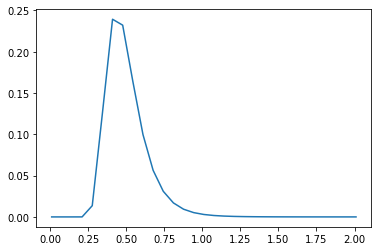

In [109]:
from utils import marginal

posterior_sigma = marginal(posterior3, 0)
posterior_sigma.plot()

In [110]:
posterior_pmf = marginal(posterior3, 1)
posterior_pmf.shape

(2091,)

In [111]:
posterior_joint = posterior_pmf.unstack().transpose()
posterior_joint.shape

(41, 51)

In [112]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

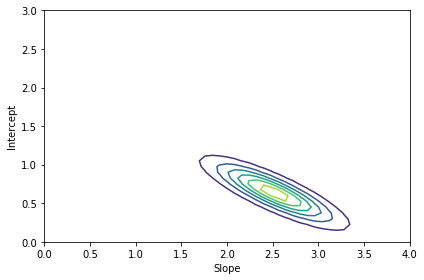

In [113]:
plot_contour(posterior_joint)

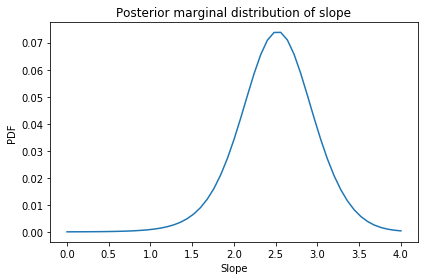

In [114]:
posterior_slope = marginal(posterior_joint, 0)

posterior_slope.plot()
decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [115]:
posterior_slope.mean(), posterior_slope.credible_interval(0.9)

(2.5055546552663173, array([1.76, 3.28]))

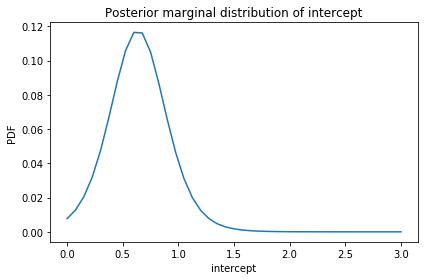

In [116]:
posterior_inter = marginal(posterior_joint, 1)

posterior_inter.plot()
decorate(xlabel='intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

In [117]:
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(0.645911304060035, array([0.225, 1.125]))

## Exercises

**Exercise:**

### The August birthday problem

This article:

[Attention Deficit–Hyperactivity Disorder and Month of School Enrollment](https://www.nejm.org/doi/10.1056/NEJMoa1806828)

Finds: 

>The rate of claims-based ADHD diagnosis among children in states with a September 1 cutoff was 85.1 per 10,000 children (309 cases among 36,319 children; 95% confidence interval [CI], 75.6 to 94.2) among those born in August and 63.6 per 10,000 children (225 cases among 35,353 children; 95% CI, 55.4 to 71.9) among those born in September, an absolute difference of 21.5 per 10,000 children (95% CI, 8.8 to 34.0); the corresponding difference in states without the September 1 cutoff was 8.9 per 10,000 children (95% CI, −14.9 to 20.8). The rate of ADHD treatment was 52.9 per 10,000 children (192 of 36,319 children; 95% CI, 45.4 to 60.3) among those born in August and 40.4 per 10,000 children (143 of 35,353 children; 95% CI, 33.8 to 47.1) among those born in September, an absolute difference of 12.5 per 10,000 children (95% CI, 2.43 to 22.4). These differences were not observed for other month-to-month comparisons, nor were they observed in states with non-September cutoff dates for starting kindergarten. In addition, in states with a September 1 cutoff, no significant differences between August-born and September-born children were observed in rates of asthma, diabetes, or obesity.

It includes this figure:

![](https://www.nejm.org/na101/home/literatum/publisher/mms/journals/content/nejm/2018/nejm_2018.379.issue-22/nejmoa1806828/20190131/images/img_xlarge/nejmoa1806828_f1.jpeg)

However, there is an error in this figure, confirmed by personal correspondence:

>The May and June [diagnoses] are reversed. May should be 317 (not 287) and June should be 287 (not 317).


Based on this corrected data, what can we say about the probability of diagnosis as a function of birth month?

What can we say about the rate of misdiagnosis?

In [118]:
n = np.array([32690, 31238, 34405, 34565, 34977, 34415, 
                   36577, 36319, 35353, 34405, 31285, 31617])

k = np.array([265, 280, 307, 312, 317, 287, 
                      320, 309, 225, 240, 232, 243])

In [119]:
x = np.arange(12)
n = np.roll(n, -8)
k = np.roll(k, -8)

In [120]:
data = pd.DataFrame(dict(x=x, k=k, n=n))
data['rate'] = data['k'] / data['n'] * 10000
data

,x,k,n,rate
0,0,225,35353,63.643821
1,1,240,34405,69.757303
2,2,232,31285,74.156944
3,3,243,31617,76.857387
4,4,265,32690,81.064546
5,5,280,31238,89.634420
6,6,307,34405,89.231216
7,7,312,34565,90.264719
8,8,317,34977,90.630986
9,9,287,34415,83.393869


In [121]:
def plot_data(data):
    plt.plot(data['x'], data['rate'], 'o', 
         color='C1', alpha=0.5)
    decorate(xlabel='Birth date, months after cutoff',
             ylabel='Diagnosis rate per 10,000')

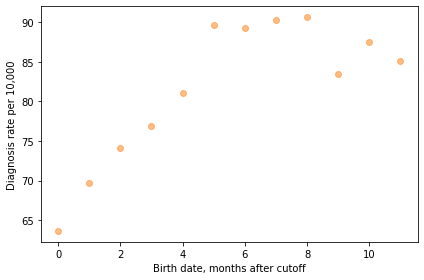

In [122]:
plot_data(data)

For the first 9 months, from September to May, we see what we would expect if at least some of the excess diagnoses are due to behavioral differences due to age.  For each month of difference in age, we see an increase in the number of diagnoses.

This pattern breaks down for the last three months, June, July, and August.  This might be explained by random variation, but it also might be due to parental manipulation; if some parents hold back students born near the deadline, the observations for these month would include a mixture of children who are relatively old for their grade, and therefore less likely to be diagnosed.

We could test this hypothesis by checking the actual ages of these students when they started school, rather than just looking at their months of birth.


In [123]:
inter = -5
slope = 0.01

In [124]:
xs = data['x']
ps = expit(inter + slope * xs)
ps

0     0.006693
1     0.006760
2     0.006827
3     0.006895
4     0.006964
5     0.007034
6     0.007104
7     0.007175
8     0.007246
9     0.007319
10    0.007392
11    0.007465
Name: x, dtype: float64

In [125]:
rate = ps * 10000

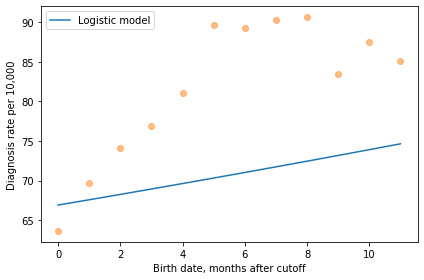

In [126]:
rate.plot(color='C0', label='Logistic model')

plot_data(data)

In [127]:
from scipy.stats import binom

ks = data['k']
ns = data['n']
likes = binom.pmf(ks, ns, ps)

In [128]:
likes.prod()

1.102452623753274e-39

In [129]:
inters = np.linspace(-5.2, -4.6, 51)
prior_inter = Pmf(1.0, inters)
prior_inter.index.name = 'Intercept'

In [130]:
slopes = np.linspace(0.0, 0.08, 51)
prior_slope = Pmf(1.0, slopes)
prior_slope.index.name = 'Slope'

In [131]:
joint = make_joint(prior_inter, prior_slope)
joint.head()

Intercept,-5.200,-5.188,-5.176,-5.164,-5.152,-5.140,-5.128,-5.116,-5.104,-5.092,...,-4.708,-4.696,-4.684,-4.672,-4.660,-4.648,-4.636,-4.624,-4.612,-4.600
Slope,,,,,,,,,,,,,,,,,,,,,
0.0000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0016,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0032,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0048,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0064,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [132]:
joint_pmf = Pmf(joint.stack())
joint_pmf.head()

Slope  Intercept
0.0    -5.200       1.0
       -5.188       1.0
       -5.176       1.0
       -5.164       1.0
       -5.152       1.0
dtype: float64

In [133]:
num_legit = 7
data1 = data.loc[0:num_legit]
data2 = data.loc[num_legit+1:]
data1

,x,k,n,rate
0,0,225,35353,63.643821
1,1,240,34405,69.757303
2,2,232,31285,74.156944
3,3,243,31617,76.857387
4,4,265,32690,81.064546
5,5,280,31238,89.634420
6,6,307,34405,89.231216
7,7,312,34565,90.264719


In [134]:
data2

,x,k,n,rate
8,8,317,34977,90.630986
9,9,287,34415,83.393869
10,10,320,36577,87.486672
11,11,309,36319,85.079435


In [135]:
likelihood1 = joint_pmf.copy()

xs = data1['x']
ks = data1['k']
ns = data1['n']

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.pmf(ks, ns, ps)
    likelihood1.loc[slope, inter] = likes.prod()

In [136]:
likelihood1.sum()

4.136745938719928e-12

In [137]:
likelihood2 = joint_pmf.copy()

xs = data2['x']
ks = data2['k']
ns = data2['n']

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.sf(ks, ns, ps)
    likelihood2.loc[slope, inter] = likes.prod()

In [138]:
likelihood2.sum()

1683.6808206806263

In [139]:
posterior_pmf = joint_pmf * likelihood1
posterior_pmf.normalize()

4.136745938719928e-12

In [140]:
posterior_pmf.max_prob()

(0.049600000000000005, -5.008)

In [141]:
posterior_pmf = joint_pmf * likelihood1 * likelihood2
posterior_pmf.normalize()

3.6151340714493297e-12

In [142]:
posterior_pmf.max_prob()

(0.0528, -5.02)

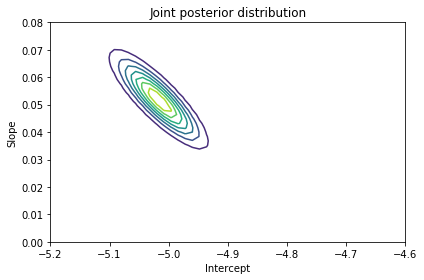

In [143]:
joint_posterior = posterior_pmf.unstack()

plot_contour(joint_posterior)
decorate(title='Joint posterior distribution')

In [144]:
marginal_inter = marginal(joint_posterior, 0)
marginal_slope = marginal(joint_posterior, 1)

marginal_inter.mean(), marginal_slope.mean()

(-5.01743458755419, 0.05194281830277113)

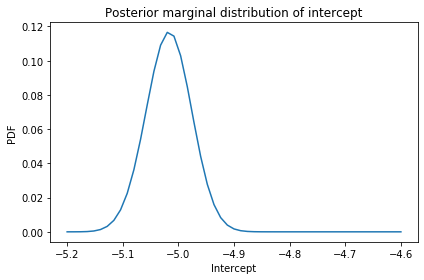

In [145]:
marginal_inter.plot()
decorate(xlabel='Intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

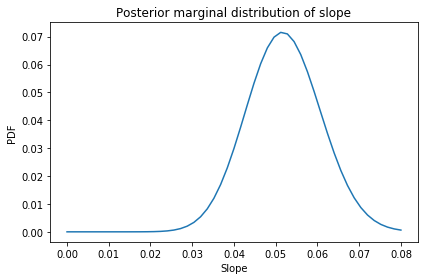

In [146]:
marginal_slope.plot()

decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [147]:
sample = posterior_pmf.sample(101)
xs = data['x']
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    pred[i] = expit(inter + slope * xs)
    
pred.shape

(101, 12)

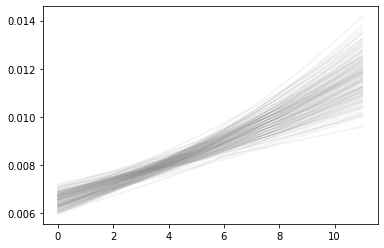

In [148]:
for ps in pred:
    plt.plot(xs, ps, color='gray', alpha=0.1)

In [149]:
low, median, high = np.percentile(pred, [2.5, 50, 97.5], axis=0)
median

array([0.00656119, 0.0069035 , 0.0072693 , 0.00766041, 0.0080788 ,
       0.00852661, 0.00896342, 0.00946729, 0.00999129, 0.01056069,
       0.01111811, 0.01173239])

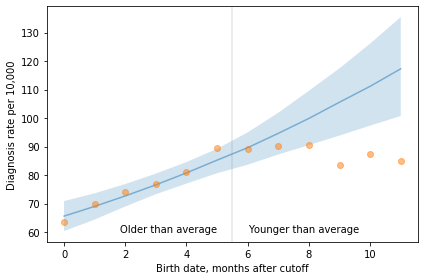

In [150]:
plt.fill_between(xs, low*10000, high*10000, alpha=0.2)
plt.plot(xs, median*10000, alpha=0.5)

plt.axvline(5.5, color='gray', alpha=0.2)
plt.text(6, 60, 'Younger than average')
plt.text(5, 60, 'Older than average', horizontalalignment='right')

plot_data(data)

## Censored regression

In [165]:
gss = pd.read_hdf(datafile, 'gss')
gss.shape

(64814, 166)

In [166]:
gss.groupby('year')['realinc'].max()

year
1972    109355.000000
1973     93210.000000
1974     94738.000000
1975     86496.000000
1976     79340.000000
1977    162607.000000
1978    143778.000000
1980    128141.000000
1982     90722.000000
1983    110895.000000
1984     92858.000000
1985     99257.000000
1986    102084.000000
1987     90278.000000
1988     91587.000000
1989     88133.000000
1990     99988.000000
1991     90265.000000
1993    103880.000000
1994     99956.000000
1996    102565.000000
1998    115841.000000
2000    141038.000000
2002    137237.765625
2004    128434.609375
2006    144502.718750
2008    146153.671875
2010    119606.062500
2012    155139.968750
2014    134817.437500
2016    131676.687500
2018    119879.414062
Name: realinc, dtype: float32

In [167]:
gss['rincome'].value_counts()

12.0    14957
9.0      4876
11.0     3838
10.0     3838
2.0      1865
8.0      1745
1.0      1306
3.0      1243
5.0      1091
4.0      1055
6.0       993
7.0       981
Name: rincome, dtype: int64

In [168]:
valid = gss.dropna(subset=['rincome', 'realinc'])
valid.shape

(36916, 166)

In [171]:
for name, group in valid.groupby('year'):
    print(name, len(group))
    plt.plot(group['income'], group['realinc'], 'o', alpha=0.3)
    break

1974 826


KeyError: 'income'

In [172]:
valid = gss.dropna(subset=['realinc', 'polviews'])
valid.shape

(50191, 166)

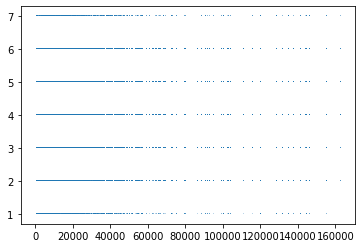

In [175]:
plt.plot(valid['realinc'], valid['polviews'], ',', alpha=0.3)